# **1.10 Creating a High Fidelity Dataset from Experimental Data**

In [1]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.1.dev'

In [6]:
!pip install pubchempy

In [7]:
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

In [9]:
import deepchem as dc
dc.utils.download_url(
    'https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
    current_dir,
    'Positive Modulators Summary_ 918.TUC _ v1.xlsx'
)

In [10]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [11]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.868936,6.747049,14.119261,-10.40397,-18.192942
3,2,1-A03,Mycophenolate Mofetil,-12.868936,6.747049,14.119261,-12.445268,-11.717468
4,3,1-A04,Metaxalone,-12.868936,6.747049,14.119261,-8.655724,-17.775287


In [12]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [13]:
# preview cleaner dataframe
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.40397,-18.192942
1,3,Mycophenolate Mofetil,-12.445268,-11.717468
2,4,Metaxalone,-8.655724,-17.775287
3,5,Terazosin·HCl,-11.504804,16.082458
4,6,Fluvastatin·Na,-11.135366,-14.553018


In [14]:
drugs = raw_data['drug'].values

In [15]:
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [16]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

/tmp/ipython-input-659224823.py:1: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  get_compounds(drugs[1], 'name')[0].canonical_smiles


'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

In [17]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)

    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

In [18]:
smiles_map = {}
for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
    except:
        print("Errored on %s" % i)
        continue

/tmp/ipython-input-2737802392.py:26: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  smiles = get_compounds(cid)[0].canonical_smiles


Errored on 7


In [19]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [20]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018


데이터 cleaning -> 약물이름을 smiles로 변환 (PubChem에서 가져옴)
-> 예외처리

#Data de-noising

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

Text(0, 0.5, 'probability')

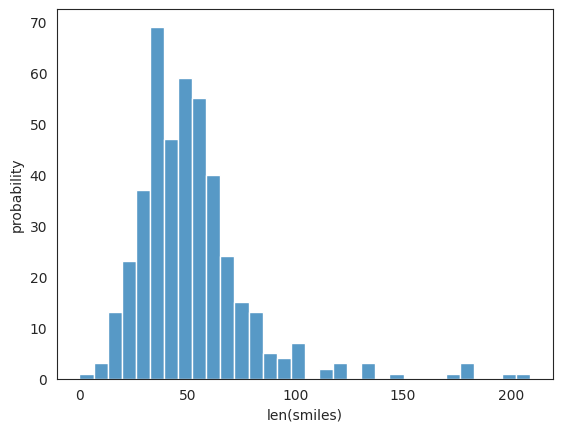

In [22]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

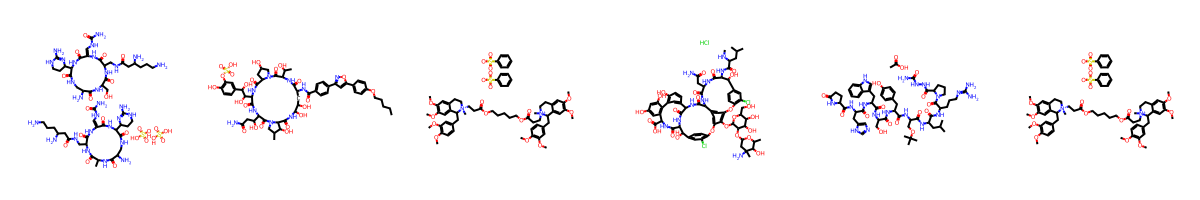

In [23]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

목표 -> 작은분자모형 만들기

smiles > 150 이면 분자가 큼 -> 데이터세트에서 제거  (크다는 이유로 억제제로 인식 될 수 있음)

In [25]:
# drop large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

In [26]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
7,-9.590272,-9.546986
62,NaN,-7.826604
175,NaN,-6.612245
187,NaN,-8.233257
233,-8.21781,NaN
262,NaN,-12.878803
288,NaN,-2.34264
300,NaN,-8.199364
301,NaN,-10.46326
311,NaN,-8.787216


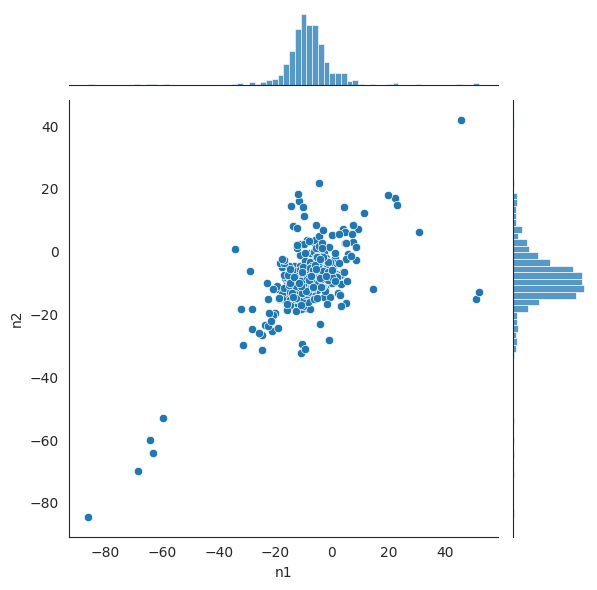

In [27]:
df = smiles_data.dropna(axis=0, how='any')
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data)

Text(0, 0.5, 'probability')

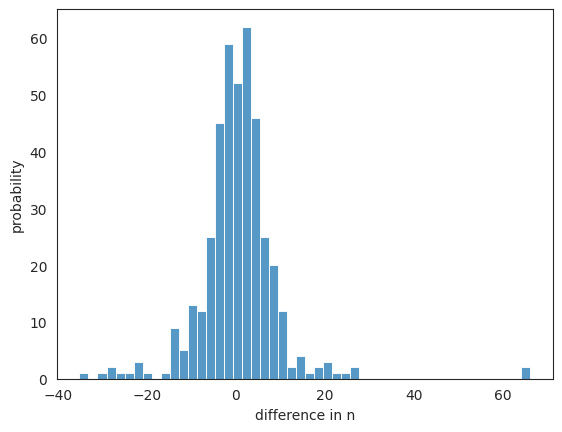

In [28]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

n1=n2여야 하므로 너무 튀는 값들 제거

In [29]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.789867401123047

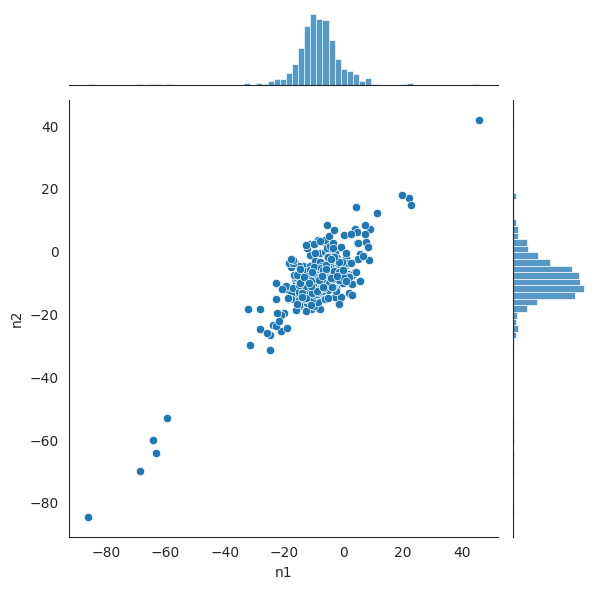

In [30]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df)

In [31]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

Text(0, 0.5, 'activity')

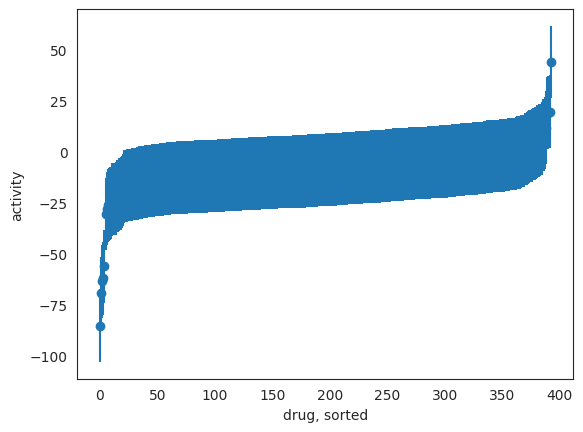

In [32]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

<ErrorbarContainer object of 3 artists>

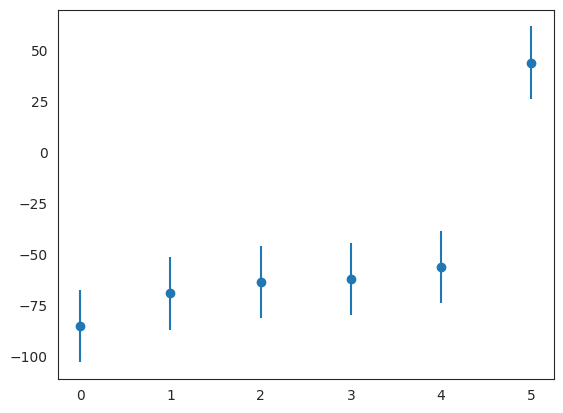

In [33]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [34]:
# summary
print (raw_data.shape, avg_df.shape, len(actives.index))

(430, 5) (393, 3) 6


In [35]:
# 1 if condition for active is met, 0 otherwise
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

In [36]:
avg_df.to_csv('modulators.csv', index=False)

In [ ]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [38]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

In [39]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')

# 💡 Insight & Reflection

데이터 특성에 맞게 기준정하고 노이즈 제거

가중치 조절로 데이터 불균형 극복

신뢰구간과 임계값으로 통계적 신뢰성 확보